# Libraries

In [10]:
import requests
import pandas as pd
from time import sleep
import time
from missingno import matrix

## Removing column limit

In [2]:
# Remove all limits for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

# Data import

## URL & RID

In [3]:
BASE = "https://data.sanjoseca.gov/api/3/action/datastore_search"

In [4]:
RESOURCE_IDS = {
    "FY18-19": "e07604f7-3a93-411e-80b8-65cf07610747",  # from earlier link
    "FY19-20": "18f65444-987a-4b1d-b33a-88418c5e74f6",
    "FY20-21": "990cae02-60c6-4836-9f3b-d5d226a8e60c",
    "FY21-22": "3e31a331-c132-412e-90be-519681936ed1",
    "FY22-23": "a5d63c03-f270-4323-a86d-9daa6d1d7bdf",
    "FY23-24": "2a130c41-ca89-4084-9a28-19709b3f24dd",
    "FY24-25": "f3354a37-7e03-41f8-a94d-3f720389a68a",
}

## Extraction function from API

In [5]:
def fetch_resource(rid: str, chunk: int = 10_000) -> pd.DataFrame:
    """Return *all* rows for a single CKAN resource_id as a DataFrame."""
    rows, offset, total = [], 0, None

    while True:
        params = {"resource_id": rid, "limit": chunk, "offset": offset}
        res = requests.get(BASE, params=params, timeout=30).json()["result"]

        if total is None:
            total = res["total"]
            print(f"▶ {rid}  rows: {total:,}")

        rows.extend(res["records"])
        offset += chunk
        if offset >= total:
            break
        time.sleep(0.25)        # be nice to the server

    return pd.DataFrame(rows)

## Function run for Dataframe

In [6]:
frames = [fetch_resource(rid).assign(fy=fy)         # keep a FY column if useful
          for fy, rid in RESOURCE_IDS.items()]

▶ e07604f7-3a93-411e-80b8-65cf07610747  rows: 21,628
▶ 18f65444-987a-4b1d-b33a-88418c5e74f6  rows: 17,759
▶ 990cae02-60c6-4836-9f3b-d5d226a8e60c  rows: 17,906
▶ 3e31a331-c132-412e-90be-519681936ed1  rows: 18,404
▶ a5d63c03-f270-4323-a86d-9daa6d1d7bdf  rows: 15,213
▶ 2a130c41-ca89-4084-9a28-19709b3f24dd  rows: 19,538
▶ f3354a37-7e03-41f8-a94d-3f720389a68a  rows: 17,814


In [7]:
df_all = pd.concat(frames, ignore_index=True)

In [8]:
print("\n Combined shape:", df_all.shape)


 Combined shape: (128262, 23)


## Data preview

In [9]:
df_all.head()

,_id,AnimalID,AnimalName,AnimalType,PrimaryColor,SecondaryColor,PrimaryBreed,Sex,DOB,Age,IntakeDate,IntakeCondition,IntakeType,IntakeSubtype,IntakeReason,OutcomeDate,OutcomeType,OutcomeSubtype,OutcomeCondition,Crossing,Jurisdiction,LastUpdate,fy
0,1,A0285916,TIGGER / TOFU,CAT,TABBY-GRAY,None,DOMESTIC SH,NEUTERED,1999-02-23,21 YEARS,2018-11-29,OTHER MED,STRAY,OTC,None,2018-11-30,RTO,None,MANAGE,"500 BLOCK E SANTA CLARA ST, SAN JOSE CA 95112",SAN JOSE,2018-11-30,FY18-19
1,2,A0295477,MILTON,CAT,TABBY-GRAY,None,DOMESTIC SH,NEUTERED,2001-05-20,24 YEARS,2018-11-11,OTHER MED,STRAY,OTC,None,2018-11-30,RESCUE,None,MANAGE,HARDWOOD RD,None,2018-11-30,FY18-19
2,3,A0302361,None,CAT,TABBY-BRN,None,DOMESTIC SH,SPAYED,2001-05-09,17 YEARS,2019-02-11,DEAD,DISPO REQ,FIELD,None,2019-02-11,DISPOSAL,None,DEAD,1600 BLOCK VALLEY CREST,SAN JOSE,2019-02-11,FY18-19
3,4,A0306304,CLAIRE,CAT,GRAY,WHITE,DOMESTIC SH,SPAYED,2001-05-24,24 YEARS,2019-03-28,NORMAL,STRAY,FOUND,None,2019-07-09,FOUND EXP,None,None,"300 BLOCK BROOKWOOD AVE, SAN JOSE CA 95116",SAN JOSE,2019-07-09,FY18-19
4,5,A0324842,NAKO,CAT,BLACK,None,DOMESTIC SH,SPAYED,2001-06-17,17 YEARS,2019-02-06,DEAD,DISPO REQ,OTC OWNED,None,2019-02-06,DISPOSAL,None,DEAD,None,SAN JOSE,2019-02-06,FY18-19


# EDA

## Missing values

<Axes: >

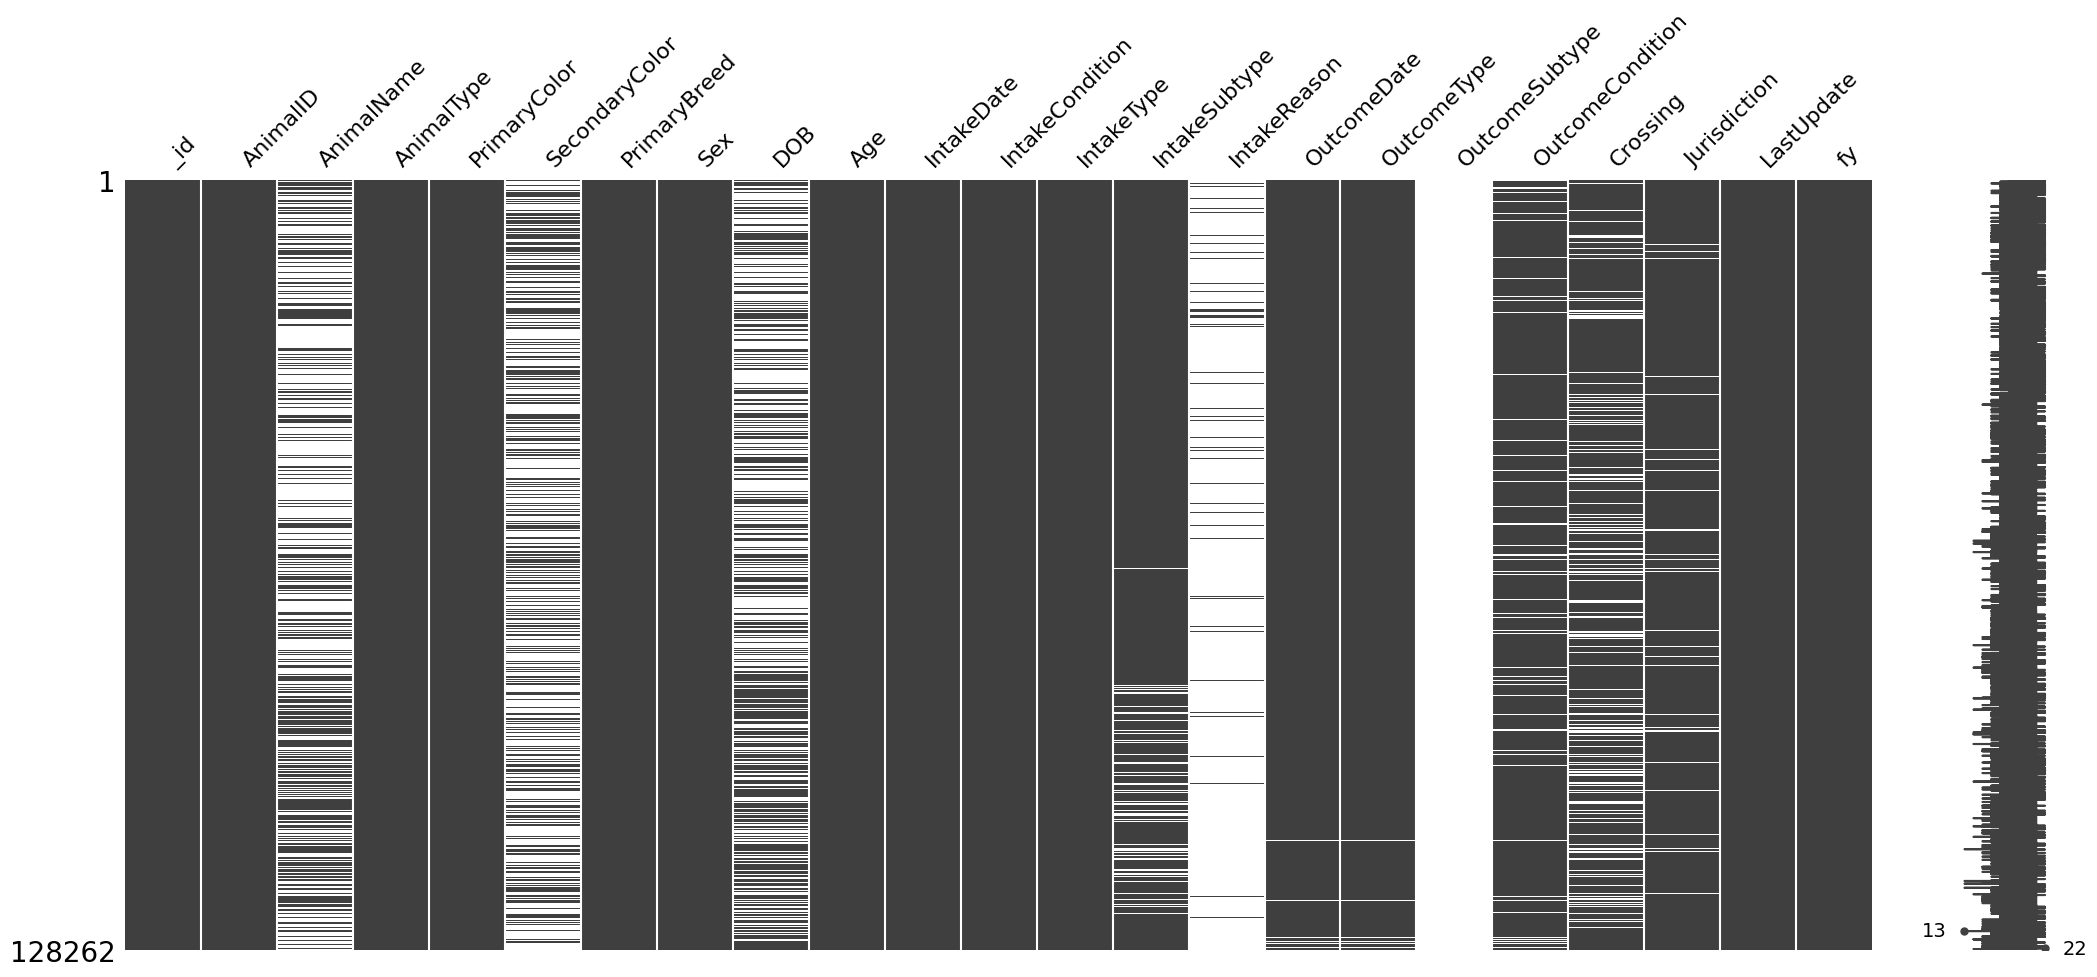

In [11]:
matrix(df_all)

In [12]:
# Percentage of missing values
missing_percent = df_all.isnull().mean() * 100
print(missing_percent)

_id                   0.000000
AnimalID              0.000000
AnimalName           57.996913
AnimalType            0.000000
PrimaryColor          0.000780
SecondaryColor       59.083750
PrimaryBreed          0.000000
Sex                   0.000000
DOB                  51.603749
Age                   0.000000
IntakeDate            0.000000
IntakeCondition       0.000000
IntakeType            0.000000
IntakeSubtype         7.169700
IntakeReason         94.625844
OutcomeDate           0.842026
OutcomeType           0.850603
OutcomeSubtype      100.000000
OutcomeCondition      7.157225
Crossing             19.038375
Jurisdiction          2.893297
LastUpdate            0.000000
fy                    0.000000
dtype: float64


# Insights from EDA

1. Drop columns *OutcomeSubtype*, *IntakeReason*, *fy*, *DOB*, *AnimalName*, *_id*, 